In [11]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd


In [12]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

In [13]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 
  

categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)

In [14]:
y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.75, random_state=42)

#try standardising
x_mean, x_std = x_tr.mean(dim=0), x_tr.std(dim=0)
x_tr = (x_tr - x_mean) / x_std
x_te = (x_te - x_mean) / x_std

In [15]:
class BlockCovGaussianLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim,
        prior_var=1,
        pre_trained_values=None,
        activation = nn.ReLU(),
        init_var=1e-3   
    ):
        super(BlockCovGaussianLayer,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.param_dim = self.input_dim + self.input_dim*self.output_dim # bias + weight

        # Prior parameters
        if pre_trained_values is None:
            self.mu_p = torch.zeros(self.param_dim)
            chol_p = torch.eye(self.param_dim)

            # bias prior
            chol_p[:self.input_dim, :self.input_dim] *= torch.sqrt(torch.tensor(prior_var))

            # weight prior
            chol_p[self.input_dim: , :self.input_dim:] *= torch.sqrt(torch.tensor(prior_var * 2 / self.output_dim))


            # Assign the result to self.chol_p
            self.chol_p = chol_p
        else:
            self.mu_p = pre_trained_values["mu_p"]
            self.chol_p = pre_trained_values["chol_p"]

        # Variational parameters
        self.mu_q = nn.Parameter(torch.zeros(self.param_dim))
        # self.chol_q = nn.Parameter(torch.eye(self.param_dim) * torch.log(torch.tensor(prior_var)))
        self.chol_q = nn.Parameter(torch.eye(self.param_dim)*torch.log((torch.tensor(init_var))))

    def p(self):
        """Weight prior distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=(self.chol_p))
        
    def q(self):
        chol = torch.tril(self.chol_q, -1) + torch.diag_embed(torch.exp(torch.diag(self.chol_q)))
        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=chol)

    def kl(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()
    
    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters and detach them from the hyperparameters graph
        param_sample = self.q().rsample((num_samples,))
        biases = param_sample[:,:self.input_dim].unsqueeze(1)  # Shape: (num_samples, 1, input_dim)
        weights = param_sample[:,self.input_dim:]
        weights = weights.view(num_samples, self.input_dim, self.output_dim)  # Reshape to (num_samples, input_dim, output_dim)

        return self.activation(x + biases) @ weights

In [16]:
class weightLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim,
        prior_var=1,
        pre_trained_values=None,
        init_var=1e-3   
        ):
        super(weightLayer,self).__init__()
    
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters
        if pre_trained_values is None:
            self.mu_p = torch.zeros(self.input_dim*self.output_dim)
            self.chol_p = torch.eye(self.input_dim*self.output_dim) * torch.sqrt(torch.tensor(prior_var * 2 / self.output_dim))#* torch.sqrt(torch.tensor(prior_var))
        else:
            self.mu_p = pre_trained_values["mu_p"]
            self.chol_p = pre_trained_values["chol_p"]

        self.mu_q = nn.Parameter(torch.zeros(self.input_dim*self.output_dim),requires_grad=True)
        # self.chol_q = nn.Parameter(torch.eye(self.input_dim*self.output_dim)*torch.log((torch.tensor(prior_var)))) # might want to reduce this to speed up learning
        self.chol_q = nn.Parameter(torch.eye(self.input_dim*self.output_dim)*torch.log((torch.tensor(init_var)))) # might want to reduce this to speed up learning


    def p(self):
        """Weight prior distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=(self.chol_p))

    def q(self):
        """Variational weight posterior"""
        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=torch.tril(self.chol_q, -1) + torch.diag_embed(torch.exp(torch.diag(self.chol_q))))
    
    def kl(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()


    def forward(self,x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters 
        weights = self.q().rsample((num_samples,)).view(num_samples, self.input_dim, self.output_dim)

        return x @ weights

In [17]:
class biasLayer(nn.Module):
    def __init__(
        self, 
        input_dim, 
        output_dim,
        prior_var=1,
        pre_trained_values=None,
        init_var=1e-3   

        ):
        super(biasLayer,self).__init__()
    
        self.input_dim = input_dim
        self.output_dim = output_dim

        
        # Prior parameters
        if pre_trained_values is None:
            self.mu_p = torch.zeros(self.input_dim)
            self.chol_p = torch.eye(self.input_dim) * torch.sqrt(torch.tensor(prior_var))
        else:
            self.mu_p = pre_trained_values["mu_p"]
            self.chol_p = pre_trained_values["chol_p"]

        self.mu_q = nn.Parameter(torch.zeros(self.input_dim),requires_grad=True)
        self.chol_q = nn.Parameter(torch.eye(self.input_dim)*torch.log((torch.tensor(init_var)))) # might want to reduce this to speed up learning

    def p(self):
        """Weight bias distribution"""
        return torch.distributions.MultivariateNormal(self.mu_p, scale_tril=(self.chol_p))

    def q(self):
        """Variational bias posterior"""
        return torch.distributions.MultivariateNormal(self.mu_q, scale_tril=torch.tril(self.chol_q, -1) + torch.diag_embed(torch.exp(torch.diag(self.chol_q))))
    
    def kl(self):
        return torch.distributions.kl_divergence(self.q(), self.p()).sum()


    def forward(self,x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim
        num_samples = x.shape[0]

        # Sample the parameters 
        biases = self.q().rsample((num_samples,)).unsqueeze(1)

        return x + biases

In [18]:
class BlockBNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, prior_var=1, activation=nn.ReLU()):
        super(BlockBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation

        # Create blocks
        self.network = nn.ModuleList()
        
        # First block: input weights only
        self.network.append(
            weightLayer(input_dim, hidden_dims[0], prior_var=prior_var)
        )
        
        for i in range(1, len(hidden_dims)+1):
            # Each block takes input from the previous layer and maps to the next hidden dim.
            if i == len(hidden_dims):
                self.network.append(
                    BlockCovGaussianLayer(
                        input_dim=hidden_dims[i-1],
                        output_dim=self.output_dim,
                        prior_var=prior_var
                    )
                )
            else:
                self.network.append(
                    BlockCovGaussianLayer(
                        input_dim=hidden_dims[i - 1],
                        output_dim=hidden_dims[i],
                        prior_var=prior_var
                    )
                )
        self.network.append(biasLayer(output_dim, output_dim, prior_var=prior_var))
            
        self.network.append(nn.Softmax(dim=2))
        

    def forward(self, x, num_samples = 1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape)==2,   "x.shape must be (batch_size, input_dim)."
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)             
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x
    
    def ll(self, y_obs, y_pred, num_samples=1):

        """Computes the log likelihood for a categorical model.
        
        y_pred: Tensor of shape (num_samples, n_points, output_size)
        y_obs: Tensor of shape (n_points,)
        """
        l = torch.distributions.Categorical(probs=y_pred)
        return l.log_prob(y_obs).mean(0).sum(0).squeeze()
    
    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if not isinstance(layer, nn.Softmax)])
    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)

        exp_ll = self.ll(y, y_pred)
        
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

In [19]:
bnn_model = BlockBNN(23,[10,10], 7)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

BlockBNN(
  (activation): ReLU()
  (network): ModuleList(
    (0): weightLayer()
    (1-2): 2 x BlockCovGaussianLayer(
      (activation): ReLU()
    )
    (3): biasLayer()
    (4): Softmax(dim=2)
  )
)


  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:34<00:00, 12.64it/s]


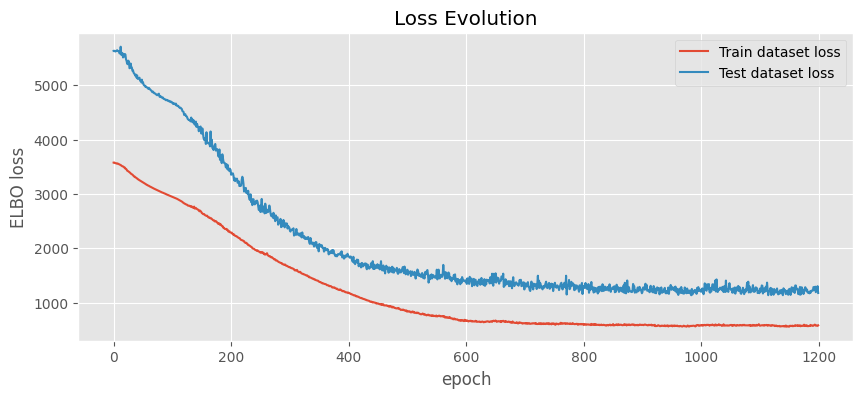

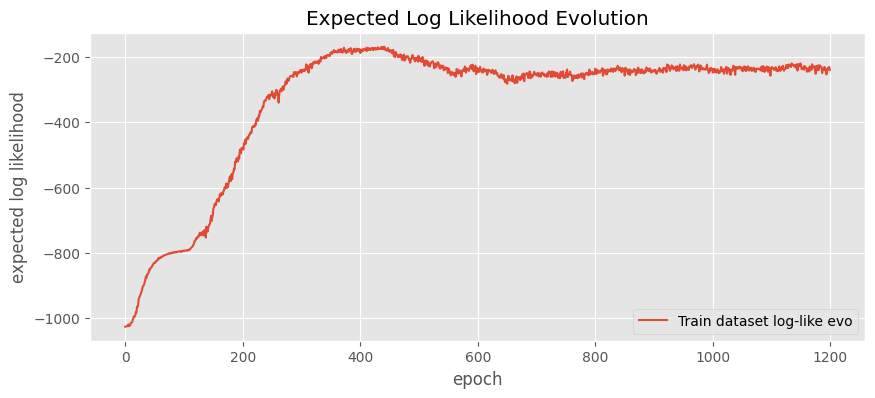

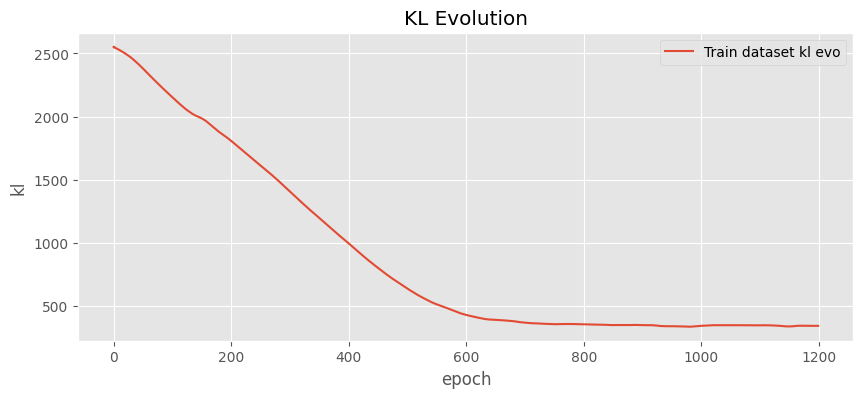

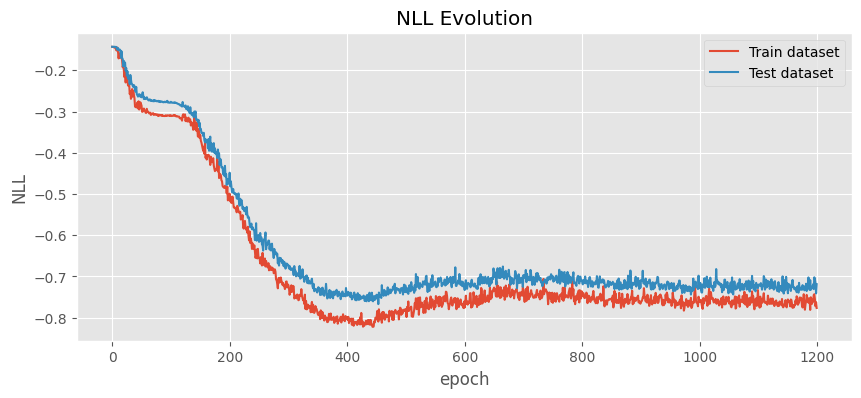

In [20]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_nll_loss_evo = []
te_nll_loss_evo = []
aux_loss = nn.NLLLoss()

for epoch in tqdm(range(1200)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples = 100)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_nll_loss_evo.append(aux_loss(bnn_model(x_tr,num_samples=10).mean(0), y_tr).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te, num_samples = 10)[0].item())
    te_nll_loss_evo.append(aux_loss(bnn_model(x_te,num_samples=10).mean(0), y_te).item())

    l.backward()
    opt.step()
    

plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_nll_loss_evo, label='Train dataset')
plt.plot(te_nll_loss_evo, label='Test dataset')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.legend()
plt.title('NLL Evolution')
plt.show()

In [21]:
preds = bnn_model(x_te,1000)
mean_preds = preds.mean(0)

In [22]:
loss = nn.NLLLoss()
loss(torch.log(mean_preds),y_te)

tensor(0.3901, grad_fn=<NllLossBackward0>)

In [23]:
indices = mean_preds.argmax(dim=1)
indices[:10]

tensor([0, 4, 0, 0, 5, 0, 3, 5, 2, 0])

In [24]:
y_te[:10]

tensor([0, 4, 0, 0, 1, 0, 3, 5, 2, 0])

In [25]:
accuracy = np.mean(np.array(indices) == np.array(y_te))
accuracy

np.float64(0.8857323232323232)